# SECCIÓN 1: Instalación de Dependencias

In [ ]:
# Instalación de librerías necesarias para el proyecto
!pip install roboflow tensorflow matplotlib scikit-learn pandas lime

# SECCIÓN 2: Importaciones y Configuración Inicial


In [ ]:
# Importaciones principales para deep learning y procesamiento de imágenes
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Importaciones específicas para LIME (explicabilidad del modelo)
import lime
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

# Configuración de semillas para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Parámetros globales del proyecto
img_height, img_width = 224, 224
batch_size = 32

# SECCIÓN 3: Descarga y Exploración del Dataset

In [ ]:
# Descarga del dataset de corales desde Roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="VBAQRpw9273AXkedUZfd")
project = rf.workspace("coralreef").project("coral-reef-bleach-detection")
version = project.version(2)
dataset = version.download("multiclass")

print(f"Dataset path: {dataset.location}")

# Definición de rutas del dataset
train_dir = os.path.join(dataset.location, 'train')
valid_dir = os.path.join(dataset.location, 'valid')
test_dir = os.path.join(dataset.location, 'test')

# Función para verificar la estructura de imágenes
def check_image_paths(directory):
    """Verifica y cuenta las imágenes disponibles en un directorio"""
    print(f"Checking {directory}...")
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']
    image_paths = []

    for root, _, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))

    print(f"Found {len(image_paths)} images in {directory}")
    if image_paths:
        print(f"Example paths: {image_paths[:3]}")

    return image_paths

# Explorar estructura del dataset
train_images = check_image_paths(train_dir)
valid_images = check_image_paths(valid_dir)
test_images = check_image_paths(test_dir)

# Verificar archivos CSV de etiquetas
train_csv = os.path.join(train_dir, '_classes.csv')
valid_csv = os.path.join(valid_dir, '_classes.csv')
test_csv = os.path.join(test_dir, '_classes.csv')

print(f"Train CSV exists: {os.path.exists(train_csv)}")
print(f"Valid CSV exists: {os.path.exists(valid_csv)}")
print(f"Test CSV exists: {os.path.exists(test_csv)}")

loading Roboflow workspace...
loading Roboflow project...
Dataset path: /content/Coral-Reef-Bleach-Detection-2
Checking /content/Coral-Reef-Bleach-Detection-2/train...
Found 10044 images in /content/Coral-Reef-Bleach-Detection-2/train
Example paths: ['/content/Coral-Reef-Bleach-Detection-2/train/youtube-28_jpg.rf.da88fcefd00b5db2e168a17903d812e1.jpg', '/content/Coral-Reef-Bleach-Detection-2/train/youtube-1531_jpg.rf.52254f5e5a3040002ea2d6ecdb6a810f.jpg', '/content/Coral-Reef-Bleach-Detection-2/train/youtube-95_jpg.rf.34c2c0ff8b1f7ee9b8f1d34d2c4c19b1.jpg']
Checking /content/Coral-Reef-Bleach-Detection-2/valid...
Found 474 images in /content/Coral-Reef-Bleach-Detection-2/valid
Example paths: ['/content/Coral-Reef-Bleach-Detection-2/valid/frame_13140_jpg.rf.5fb7eb5f3e3d0667837db49f5c51f025.jpg', '/content/Coral-Reef-Bleach-Detection-2/valid/frame_7740_jpg.rf.4f9498d1d7f858cd4cbd84f92f75fcef.jpg', '/content/Coral-Reef-Bleach-Detection-2/valid/youtube-275_jpg.rf.89ed9c3d2c22fe54693e284ba068

# SECCIÓN 4: Funciones de Carga de Datos

In [ ]:
# Función para cargar dataset desde archivos CSV (método principal)
def load_dataset_from_csv(csv_path, images_dir):
    """
    Carga dataset desde CSV con detección automática de columnas.
    Maneja diferentes formatos de CSV automáticamente.
    """
    df = pd.read_csv(csv_path)

    print(f"CSV columns: {df.columns.tolist()}")
    print(f"First few rows of {csv_path}:")
    print(df.head())

    # Detección automática de columnas
    column_names = df.columns.tolist()
    filename_col = None
    class_col = None
    filename_patterns = ['file', 'image', 'path', 'name', 'filename']
    class_patterns = ['class', 'label', 'category', 'annotation']

    for col in column_names:
        col_lower = col.lower()
        if any(pattern in col_lower for pattern in filename_patterns):
            filename_col = col
        elif any(pattern in col_lower for pattern in class_patterns):
            class_col = col

    # Fallback para detección de columnas
    if filename_col is None:
        if len(column_names) == 2:
            filename_col = column_names[0]
        else:
            for col in column_names:
                if df[col].dtype == object and any(str(val).endswith(('.jpg', '.png', '.jpeg')) for val in df[col].dropna().head()):
                    filename_col = col
                    break

    if class_col is None:
        if len(column_names) == 2:
            class_col = column_names[1]
        else:
            remaining_cols = [col for col in column_names if col != filename_col]
            if remaining_cols:
                class_col = min(remaining_cols, key=lambda col: df[col].nunique())

    print(f"Using filename column: {filename_col}")
    print(f"Using class column: {class_col}")

    if filename_col is None or class_col is None:
        raise ValueError("Could not identify filename and class columns in the CSV")

    # Procesamiento de rutas y clases
    dataset_df = pd.DataFrame()

    if filename_col is not None:
        filename_series = df[filename_col]
        has_extension = any(str(filename).lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
                           for filename in filename_series.dropna().head(10))

        if has_extension:
            dataset_df['filepath'] = filename_series.apply(
                lambda x: os.path.join(images_dir, str(x)) if not str(x).startswith(images_dir) else str(x)
            )
        else:
            dataset_df['filepath'] = filename_series.apply(
                lambda x: os.path.join(images_dir, f"{str(x)}.jpg")
            )

    if class_col is not None:
        dataset_df['class'] = df[class_col]

    dataset_df['class'] = dataset_df['class'].astype(str)
    class_names = sorted(dataset_df['class'].unique())
    class_to_idx = {cls: i for i, cls in enumerate(class_names)}
    dataset_df['class_idx'] = dataset_df['class'].map(class_to_idx)

    # Verificar existencia de archivos
    dataset_df['file_exists'] = dataset_df['filepath'].apply(os.path.exists)
    print(f"Files found: {dataset_df['file_exists'].sum()} out of {len(dataset_df)}")

    dataset_df = dataset_df[dataset_df['file_exists']].copy()
    dataset_df.drop('file_exists', axis=1, inplace=True)

    if len(dataset_df) == 0:
        raise ValueError(f"No valid image files found using the paths from {csv_path}")

    return dataset_df, class_names, class_to_idx

# SECCIÓN 5: Generador de Datos Personalizado

In [ ]:
# Generador de datos personalizado con data augmentation
class DataGenerator(tf.keras.utils.Sequence):
    """
    Generador personalizado para cargar imágenes en batches con opciones de augmentación.
    Optimizado para datasets de detección de corales.
    """
    def __init__(self, dataframe, class_to_idx, batch_size=32, img_size=(224, 224),
                 shuffle=True, augment=False):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.class_to_idx = class_to_idx
        self.n_classes = len(class_to_idx)
        self.indexes = np.arange(len(dataframe))
        self.on_epoch_end()

        # Configuración de data augmentation específica para corales
        if augment:
            self.datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest'
            )
        else:
            self.datagen = None

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.dataframe.iloc[batch_indexes]

        batch_x = np.zeros((len(batch_df), *self.img_size, 3), dtype=np.float32)
        batch_y = np.zeros((len(batch_df), self.n_classes), dtype=np.float32)

        # Carga y preprocesamiento de imágenes
        for i, (_, row) in enumerate(batch_df.iterrows()):
            img_path = row['filepath']
            try:
                img = load_img(img_path, target_size=self.img_size)
                img_array = img_to_array(img) / 255.0  # Normalización

                # Aplicar data augmentation si está habilitado
                if self.augment and self.datagen:
                    img_array = self.datagen.random_transform(img_array)

                batch_x[i] = img_array
                # One-hot encoding para las etiquetas
                batch_y[i] = to_categorical(row['class_idx'], num_classes=self.n_classes)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                batch_x[i] = np.zeros((*self.img_size, 3), dtype=np.float32)
                batch_y[i] = to_categorical(0, num_classes=self.n_classes)

        return batch_x, batch_y

# SECCIÓN 6: Carga de Datos con Fallback

In [ ]:
# Intento de carga desde CSV con fallback a directorios
try:
    print("\nIntentando cargar dataset desde archivos CSV...")
    train_df, class_names, class_to_idx = load_dataset_from_csv(train_csv, train_dir)
    valid_df, _, _ = load_dataset_from_csv(valid_csv, valid_dir)
    test_df, _, _ = load_dataset_from_csv(test_csv, test_dir)

    print(f"Loaded {len(train_df)} training samples")
    print(f"Loaded {len(valid_df)} validation samples")
    print(f"Loaded {len(test_df)} test samples")
    print(f"Classes: {class_names}")

    num_classes = len(class_names)

    # Crear generadores de datos
    train_generator = DataGenerator(train_df, class_to_idx, batch_size=batch_size,
                                   img_size=(img_height, img_width), augment=True)
    validation_generator = DataGenerator(valid_df, class_to_idx, batch_size=batch_size,
                                        img_size=(img_height, img_width), shuffle=False)
    test_generator = DataGenerator(test_df, class_to_idx, batch_size=batch_size,
                                  img_size=(img_height, img_width), shuffle=False)

except Exception as e:
    print(f"Error loading dataset from CSV: {e}")
    print("\nUsando método alternativo basado en directorios...")

    # Método alternativo usando ImageDataGenerator de Keras
    from tensorflow.keras.preprocessing.image import ImageDataGenerator

    # Configuración de data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    valid_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Encontrar directorios de imágenes
    def find_image_dir(base_dir):
        images_dir = os.path.join(base_dir, 'images')
        if os.path.exists(images_dir) and os.path.isdir(images_dir):
            return images_dir
        return base_dir

    train_images_dir = find_image_dir(train_dir)
    valid_images_dir = find_image_dir(valid_dir)
    test_images_dir = find_image_dir(test_dir)

    def has_class_subdirs(directory):
        subdirs = [d for d in os.listdir(directory)
                  if os.path.isdir(os.path.join(directory, d)) and not d.startswith('.')]
        print(f"Found subdirectories in {directory}: {subdirs}")
        return len(subdirs) > 0

    if has_class_subdirs(train_images_dir):
        train_generator = train_datagen.flow_from_directory(
            train_images_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical'
        )

        validation_generator = valid_datagen.flow_from_directory(
            valid_images_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical'
        )

        test_generator = test_datagen.flow_from_directory(
            test_images_dir,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )

        class_names = list(train_generator.class_indices.keys())
        num_classes = len(class_names)

        print(f"Usando flow_from_directory con subdirectorios de clases")
        print(f"Classes: {class_names}")
    else:
        raise ValueError("No se pudo determinar la estructura del dataset.")

# Estandarizar nombres de clases y mostrar resumen
class_names = [str(cls) for cls in class_names]
print(f"\nClases finales: {class_names}")
print(f"Número total de clases: {num_classes}")


Intentando cargar dataset desde archivos CSV...
CSV columns: ['filename', ' Bleached', ' Healthy']
First few rows of /content/Coral-Reef-Bleach-Detection-2/train/_classes.csv:
                                            filename   Bleached   Healthy
0  youtube-1582_jpg.rf.a59f0d3d3d2112abf47ff21149...          1         0
1  youtube-593_jpg.rf.a55145f3750291a0a3542227b56...          0         1
2  youtube-255_jpg.rf.a510308b30e4616fc9089ace1fb...          1         0
3  youtube-90_jpg.rf.a53114d39e4876dc0d4b0529b870...          1         0
4  youtube-81_jpg.rf.a51b8ba74af8dffeccb15d5d8687...          1         0
Using filename column: filename
Using class column:  Bleached
Files found: 10044 out of 10044
CSV columns: ['filename', ' Bleached', ' Healthy']
First few rows of /content/Coral-Reef-Bleach-Detection-2/valid/_classes.csv:
                                            filename   Bleached   Healthy
0  youtube-56_jpg.rf.0433edfd32d5f677b6f782acef60...          1         0
1  youtub

# SECCIÓN 7: Definición y Entrenamiento del Modelo

In [ ]:
# Arquitectura CNN personalizada para detección de corales
def build_coral_detection_model(input_shape=(img_height, img_width, 3), num_classes=num_classes):
    """
    Construye una CNN optimizada para clasificación de estados de coral.
    Incluye batch normalization y dropout para mejor generalización.
    """
    model = models.Sequential([
        # Primer bloque convolucional
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Segundo bloque convolucional
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Tercer bloque convolucional
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Cuarto bloque convolucional
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Capas densas con regularización
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Crear y compilar el modelo
model = build_coral_detection_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Configurar callbacks para optimizar el entrenamiento
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'coral_detection_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Entrenar el modelo
print("\n🚀 Iniciando entrenamiento del modelo...")
epochs = 15
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint_cb, reduce_lr]
)

# Guardar modelo final
model.save('coral_detection_model_final.h5')
print("✅ Modelo guardado exitosamente")

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,268,290 (73.50 MB)

 Trainable params: 19,266,306 (73.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



🚀 Iniciando entrenamiento del modelo...
Epoch 1/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.8126 - loss: 0.6198

314/314 ━━━━━━━━━━━━━━━━━━━━ 178s 505ms/step - accuracy: 0.8127 - loss: 0.6194 - val_accuracy: 0.7616 - val_loss: 0.7516 - learning_rate: 1.0000e-04
Epoch 2/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8695 - loss: 0.3775

314/314 ━━━━━━━━━━━━━━━━━━━━ 152s 485ms/step - accuracy: 0.8695 - loss: 0.3774 - val_accuracy: 0.9262 - val_loss: 0.2041 - learning_rate: 1.0000e-04
Epoch 3/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 153s 486ms/step - accuracy: 0.8905 - loss: 0.2902 - val_accuracy: 0.9262 - val_loss: 0.1621 - learning_rate: 1.0000e-04
Epoch 4/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 152s 485ms/step - accuracy: 0.9025 - loss: 0.2467 - val_accuracy: 0.9219 - val_loss: 0.1916 - learning_rate: 1.0000e-04
Epoch 5/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9123 - loss: 0.2276

314/314 ━━━━━━━━━━━━━━━━━━━━ 153s 487ms/step - accuracy: 0.9124 - loss: 0.2275 - val_accuracy: 0.9451 - val_loss: 0.1549 - learning_rate: 1.0000e-04
Epoch 6/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 151s 481ms/step - accuracy: 0.9249 - loss: 0.2025 - val_accuracy: 0.8650 - val_loss: 0.3310 - learning_rate: 1.0000e-04
Epoch 7/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9345 - loss: 0.1742

314/314 ━━━━━━━━━━━━━━━━━━━━ 153s 487ms/step - accuracy: 0.9344 - loss: 0.1742 - val_accuracy: 0.9536 - val_loss: 0.1469 - learning_rate: 1.0000e-04
Epoch 8/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9365 - loss: 0.1738

314/314 ━━━━━━━━━━━━━━━━━━━━ 153s 486ms/step - accuracy: 0.9365 - loss: 0.1738 - val_accuracy: 0.9557 - val_loss: 0.1183 - learning_rate: 1.0000e-04
Epoch 9/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9416 - loss: 0.1484

314/314 ━━━━━━━━━━━━━━━━━━━━ 152s 485ms/step - accuracy: 0.9416 - loss: 0.1484 - val_accuracy: 0.9599 - val_loss: 0.1279 - learning_rate: 1.0000e-04
Epoch 10/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 150s 478ms/step - accuracy: 0.9400 - loss: 0.1581 - val_accuracy: 0.9536 - val_loss: 0.1424 - learning_rate: 1.0000e-04
Epoch 11/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 152s 485ms/step - accuracy: 0.9528 - loss: 0.1292 - val_accuracy: 0.9430 - val_loss: 0.1177 - learning_rate: 1.0000e-04
Epoch 12/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 151s 482ms/step - accuracy: 0.9417 - loss: 0.1571 - val_accuracy: 0.9599 - val_loss: 0.1202 - learning_rate: 1.0000e-04
Epoch 13/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9492 - loss: 0.1319

314/314 ━━━━━━━━━━━━━━━━━━━━ 152s 483ms/step - accuracy: 0.9492 - loss: 0.1318 - val_accuracy: 0.9620 - val_loss: 0.0860 - learning_rate: 1.0000e-04
Epoch 14/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9573 - loss: 0.1138

314/314 ━━━━━━━━━━━━━━━━━━━━ 151s 481ms/step - accuracy: 0.9573 - loss: 0.1139 - val_accuracy: 0.9662 - val_loss: 0.0990 - learning_rate: 1.0000e-04
Epoch 15/15
314/314 ━━━━━━━━━━━━━━━━━━━━ 153s 486ms/step - accuracy: 0.9540 - loss: 0.1157 - val_accuracy: 0.9620 - val_loss: 0.1034 - learning_rate: 1.0000e-04


✅ Modelo guardado exitosamente


# SECCIÓN 8: Evaluación y Métricas del Modelo


📊 Evaluando modelo en conjunto de test...
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9709 - loss: 0.0831
Test accuracy: 0.9658
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step

📈 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       122
           1       0.96      0.98      0.97       141

    accuracy                           0.97       263
   macro avg       0.97      0.96      0.97       263
weighted avg       0.97      0.97      0.97       263



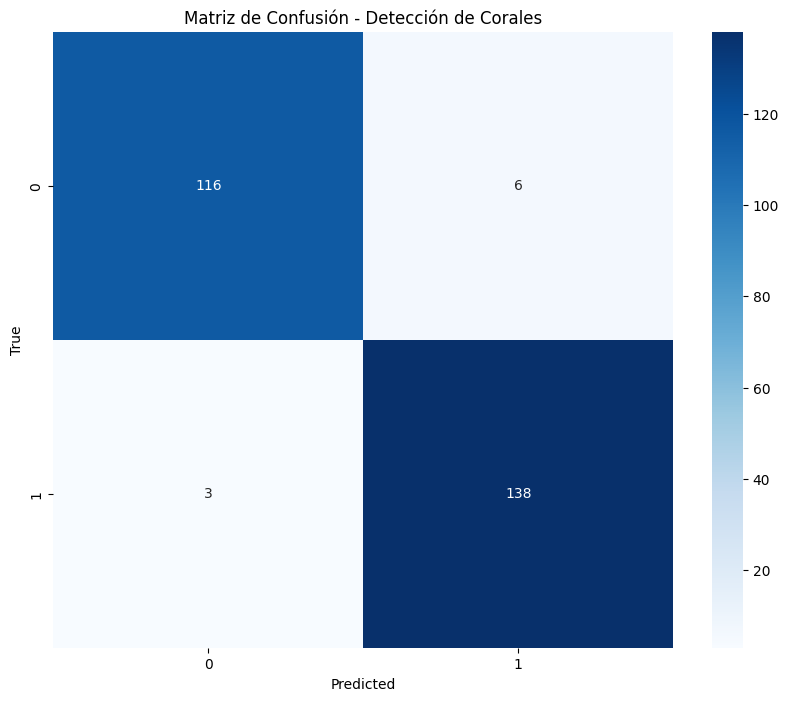

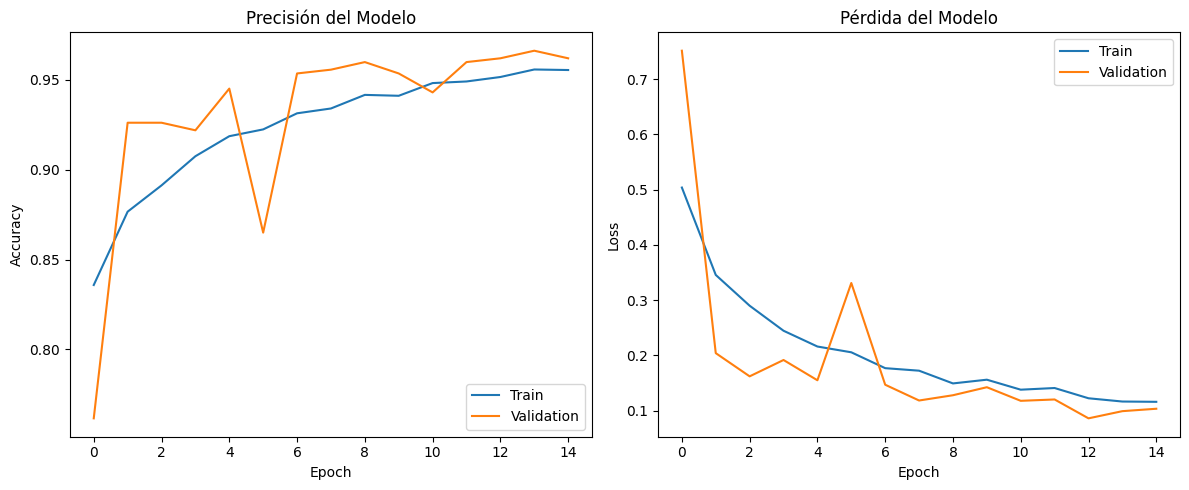

In [ ]:
# Evaluación completa del modelo en el conjunto de test
print("\n📊 Evaluando modelo en conjunto de test...")
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

# Función para recopilar predicciones del generador
def collect_predictions(generator, model, max_batches=None):
    """Recopila predicciones y etiquetas verdaderas del generador"""
    y_pred = []
    y_true = []
    batch_count = 0

    for i in range(len(generator)):
        if max_batches is not None and batch_count >= max_batches:
            break

        x_batch, y_batch = generator[i]
        pred_batch = model.predict(x_batch)
        pred_labels = np.argmax(pred_batch, axis=1)
        true_labels = np.argmax(y_batch, axis=1)

        y_pred.extend(pred_labels)
        y_true.extend(true_labels)
        batch_count += 1

    return np.array(y_true), np.array(y_pred)

# Obtener predicciones para métricas detalladas
y_true, y_pred = collect_predictions(test_generator, model)

# Reporte de clasificación detallado
print('\n📈 Classification Report:')
y_true_names = [class_names[idx] for idx in y_true]
y_pred_names = [class_names[idx] for idx in y_pred]
print(classification_report(y_true_names, y_pred_names))

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión - Detección de Corales')
plt.show()

# Gráficos de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

from sklearn.metrics import classification_report


# SECCIÓN 9: Funciones LIME para Explicabilidad


📸 Mostrando predicciones del modelo en imágenes de test...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


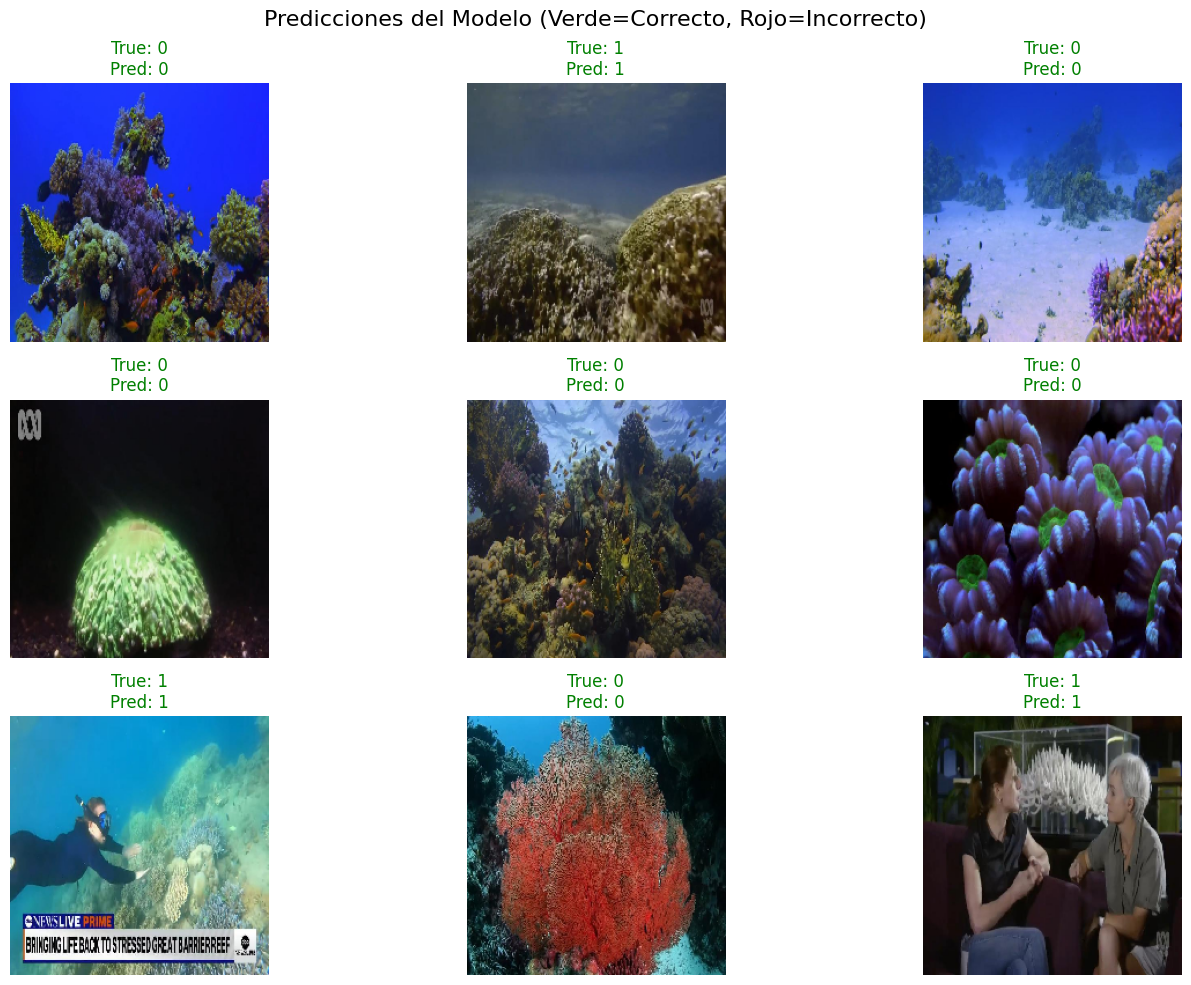

In [ ]:
# Implementación de LIME para explicar predicciones del modelo
def preprocess_image_for_lime(image_path):
    """Preprocesa imagen para compatibilidad con LIME"""
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img) / 255.0
    return img_array

def model_predict_for_lime(images):
    """Función de predicción adaptada para LIME"""
    predictions = model.predict(images)
    return predictions

def explain_coral_prediction(image_path, class_to_explain=None, num_features=10, num_samples=1000):
    """
    Genera explicaciones LIME para predicciones de coral

    Args:
        image_path: ruta de la imagen a explicar
        class_to_explain: índice de clase específica (None para todas)
        num_features: número de características a mostrar
        num_samples: número de muestras para el modelo local
    """
    # Cargar y preprocesar imagen
    image = preprocess_image_for_lime(image_path)

    # Configurar segmentación específica para texturas de coral
    segmenter = SegmentationAlgorithm('quickshift',
                                     kernel_size=4,    # Segmentos pequeños para detalles
                                     max_dist=200,     # Mayor sensibilidad
                                     ratio=0.2)

    # Inicializar explicador LIME
    explainer = lime_image.LimeImageExplainer()

    # Generar explicación
    explanation = explainer.explain_instance(
        image,
        model_predict_for_lime,
        top_labels=num_classes,
        hide_color=0,
        num_samples=num_samples,
        segmentation_fn=segmenter
    )

    return explanation, image

def visualize_lime_explanation(explanation, image, class_idx=None, save_path=None):
    """
    Crea visualización completa de explicaciones LIME para corales
    """
    if class_idx is None:
        class_idx = explanation.top_labels[0]

    # Obtener máscaras de explicación
    temp_positive, mask_positive = explanation.get_image_and_mask(
        class_idx,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    temp_all, mask_all = explanation.get_image_and_mask(
        class_idx,
        positive_only=False,
        num_features=15,
        hide_rest=False
    )

    # Crear visualización de 6 paneles
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Panel superior: análisis de contribuciones positivas
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Imagen Original del Coral', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(mark_boundaries(temp_positive, mask_positive))
    axes[0, 1].set_title(f'Regiones que APOYAN\npredicción: {class_names[class_idx]}',
                        fontsize=12, fontweight='bold', color='green')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(temp_positive)
    axes[0, 2].set_title(f'Solo regiones relevantes\npara: {class_names[class_idx]}',
                        fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')

    # Panel inferior: análisis completo
    axes[1, 0].imshow(mark_boundaries(temp_all, mask_all))
    axes[1, 0].set_title('Todas las contribuciones\n(positivas y negativas)',
                        fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')

    # Gráfico de importancia de segmentos
    segments_and_scores = explanation.local_exp[class_idx]
    segments_and_scores = sorted(segments_and_scores, key=lambda x: abs(x[1]), reverse=True)[:10]

    segments, scores = zip(*segments_and_scores)
    colors = ['green' if score > 0 else 'red' for score in scores]

    axes[1, 1].barh(range(len(scores)), scores, color=colors, alpha=0.7)
    axes[1, 1].set_yticks(range(len(scores)))
    axes[1, 1].set_yticklabels([f'Seg {seg}' for seg in segments])
    axes[1, 1].set_xlabel('Importancia del Segmento')
    axes[1, 1].set_title('Top 10 Segmentos por Importancia')
    axes[1, 1].grid(True, alpha=0.3)

    # Análisis de confianza por clase
    prediction = model.predict(np.expand_dims(image, axis=0))[0]

    axes[1, 2].bar(range(len(class_names)), prediction,
                   color=['lightcoral' if i != class_idx else 'lightgreen' for i in range(len(class_names))])
    axes[1, 2].set_xticks(range(len(class_names)))
    axes[1, 2].set_xticklabels(class_names, rotation=45)
    axes[1, 2].set_ylabel('Probabilidad')
    axes[1, 2].set_title('Confianza del Modelo por Clase')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    # Mostrar estadísticas textuales
    print(f"\n{'='*50}")
    print(f"ANÁLISIS LIME PARA: {class_names[class_idx]}")
    print(f"{'='*50}")

    positive_segments = [score for _, score in segments_and_scores if score > 0]
    negative_segments = [score for _, score in segments_and_scores if score < 0]

    print(f"🔍 Confianza del modelo: {prediction[class_idx]:.3f}")
    print(f"📊 Segmentos que apoyan la predicción: {len(positive_segments)}")
    print(f"❌ Segmentos que contradicen: {len(negative_segments)}")

    if positive_segments:
        print(f"➕ Contribución promedio positiva: {np.mean(positive_segments):.3f}")
    if negative_segments:
        print(f"➖ Contribución promedio negativa: {np.mean(negative_segments):.3f}")

# SECCIÓN 10: Funciones de Análisis y Demostración


📸 Mostrando predicciones del modelo en imágenes de test...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


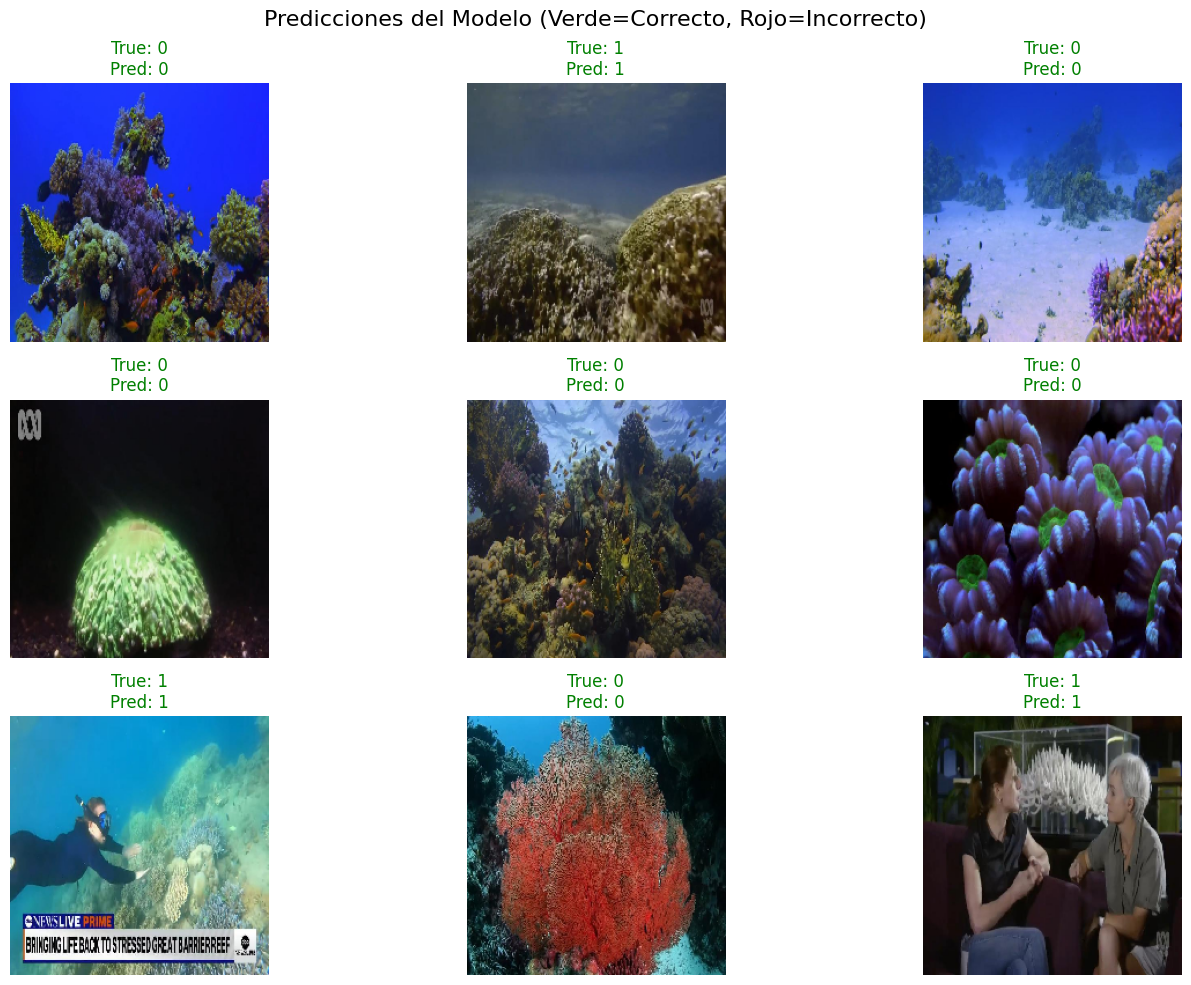

In [ ]:
# Funciones para análisis en lote y demostración
def coral_lime_batch_analysis(image_paths, output_dir='lime_explanations'):
    """Analiza múltiples imágenes de corales con LIME y guarda resultados"""
    os.makedirs(output_dir, exist_ok=True)
    results = []

    for i, img_path in enumerate(image_paths):
        try:
            print(f"\nAnalizando imagen {i+1}/{len(image_paths)}: {os.path.basename(img_path)}")

            explanation, image = explain_coral_prediction(img_path)

            # Obtener predicción principal
            prediction = model.predict(np.expand_dims(image, axis=0))[0]
            predicted_class = np.argmax(prediction)
            confidence = prediction[predicted_class]

            # Guardar visualización
            save_path = os.path.join(output_dir, f'lime_explanation_{i+1}.png')
            visualize_lime_explanation(explanation, image, predicted_class, save_path)

            results.append({
                'image_path': img_path,
                'predicted_class': class_names[predicted_class],
                'confidence': confidence,
                'explanation_saved': save_path
            })

        except Exception as e:
            print(f"Error procesando {img_path}: {e}")
            results.append({
                'image_path': img_path,
                'predicted_class': 'ERROR',
                'confidence': 0.0,
                'explanation_saved': None
            })

    # Guardar resumen
    results_df = pd.DataFrame(results)
    results_df.to_csv(os.path.join(output_dir, 'lime_analysis_summary.csv'), index=False)
    return results_df

def predict_coral_image(image_path, model, explain=False):
    """
    Función principal para predecir y explicar imágenes de coral
    """
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    result = {
        'class': class_names[predicted_class],
        'confidence': float(prediction[0][predicted_class]),
        'all_probabilities': {class_names[i]: float(prediction[0][i]) for i in range(len(class_names))}
    }

    if explain:
        print("Generando explicación LIME...")
        explanation, image = explain_coral_prediction(image_path)
        visualize_lime_explanation(explanation, image, predicted_class)
        result['lime_explanation'] = explanation

    return result

def demo_lime_coral_analysis():
    """Demostración automática de LIME con imágenes del test set"""
    print("\n" + "="*60)
    print("🐠 DEMOSTRACIÓN DE ANÁLISIS LIME EN CORALES 🐠")
    print("="*60)

    try:
        # Obtener imágenes de muestra
        if hasattr(test_generator, 'dataframe'):
            sample_images = test_generator.dataframe.sample(n=min(3, len(test_generator.dataframe)))
            image_paths = sample_images['filepath'].tolist()
        else:
            image_paths = []
            for root, dirs, files in os.walk(test_dir):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        image_paths.append(os.path.join(root, file))
                        if len(image_paths) >= 3:
                            break
                if len(image_paths) >= 3:
                    break

        if image_paths:
            for i, img_path in enumerate(image_paths[:3]):
                print(f"\n--- Análisis LIME #{i+1} ---")
                print(f"Imagen: {os.path.basename(img_path)}")

                # Realizar predicción con explicación
                result = predict_coral_image(img_path, model, explain=True)
                print(f"Predicción: {result['class']} (confianza: {result['confidence']:.3f})")
        else:
            print("No se pudieron encontrar imágenes para la demostración")

    except Exception as e:
        print(f"Error en la demostración: {e}")

# Visualizar algunas predicciones del modelo (sin LIME)
try:
    print("\n📸 Mostrando predicciones del modelo en imágenes de test...")
    x_test, y_test = test_generator[0]

    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)

    plt.figure(figsize=(15, 10))
    for i in range(min(9, len(x_test))):
        plt.subplot(3, 3, i+1)
        plt.imshow(x_test[i])
        color = 'green' if predicted_classes[i] == true_classes[i] else 'red'
        title = f"True: {class_names[true_classes[i]]}\nPred: {class_names[predicted_classes[i]]}"
        plt.title(title, color=color)
        plt.axis('off')
    plt.suptitle('Predicciones del Modelo (Verde=Correcto, Rojo=Incorrecto)', fontsize=16)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error mostrando predicciones: {e}")

# SECCIÓN 11: Resumen y Funciones Principales


🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
INICIANDO ANÁLISIS LIME
🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍

🚀 PASO 1: Ejecutando demostración automática de LIME...

🐠 DEMOSTRACIÓN DE ANÁLISIS LIME EN CORALES 🐠

--- Análisis LIME #1 ---
Imagen: youtube-206_jpg.rf.32eba2d9fabe4adda61c45a9fdd9d7bc.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Generando explicación LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

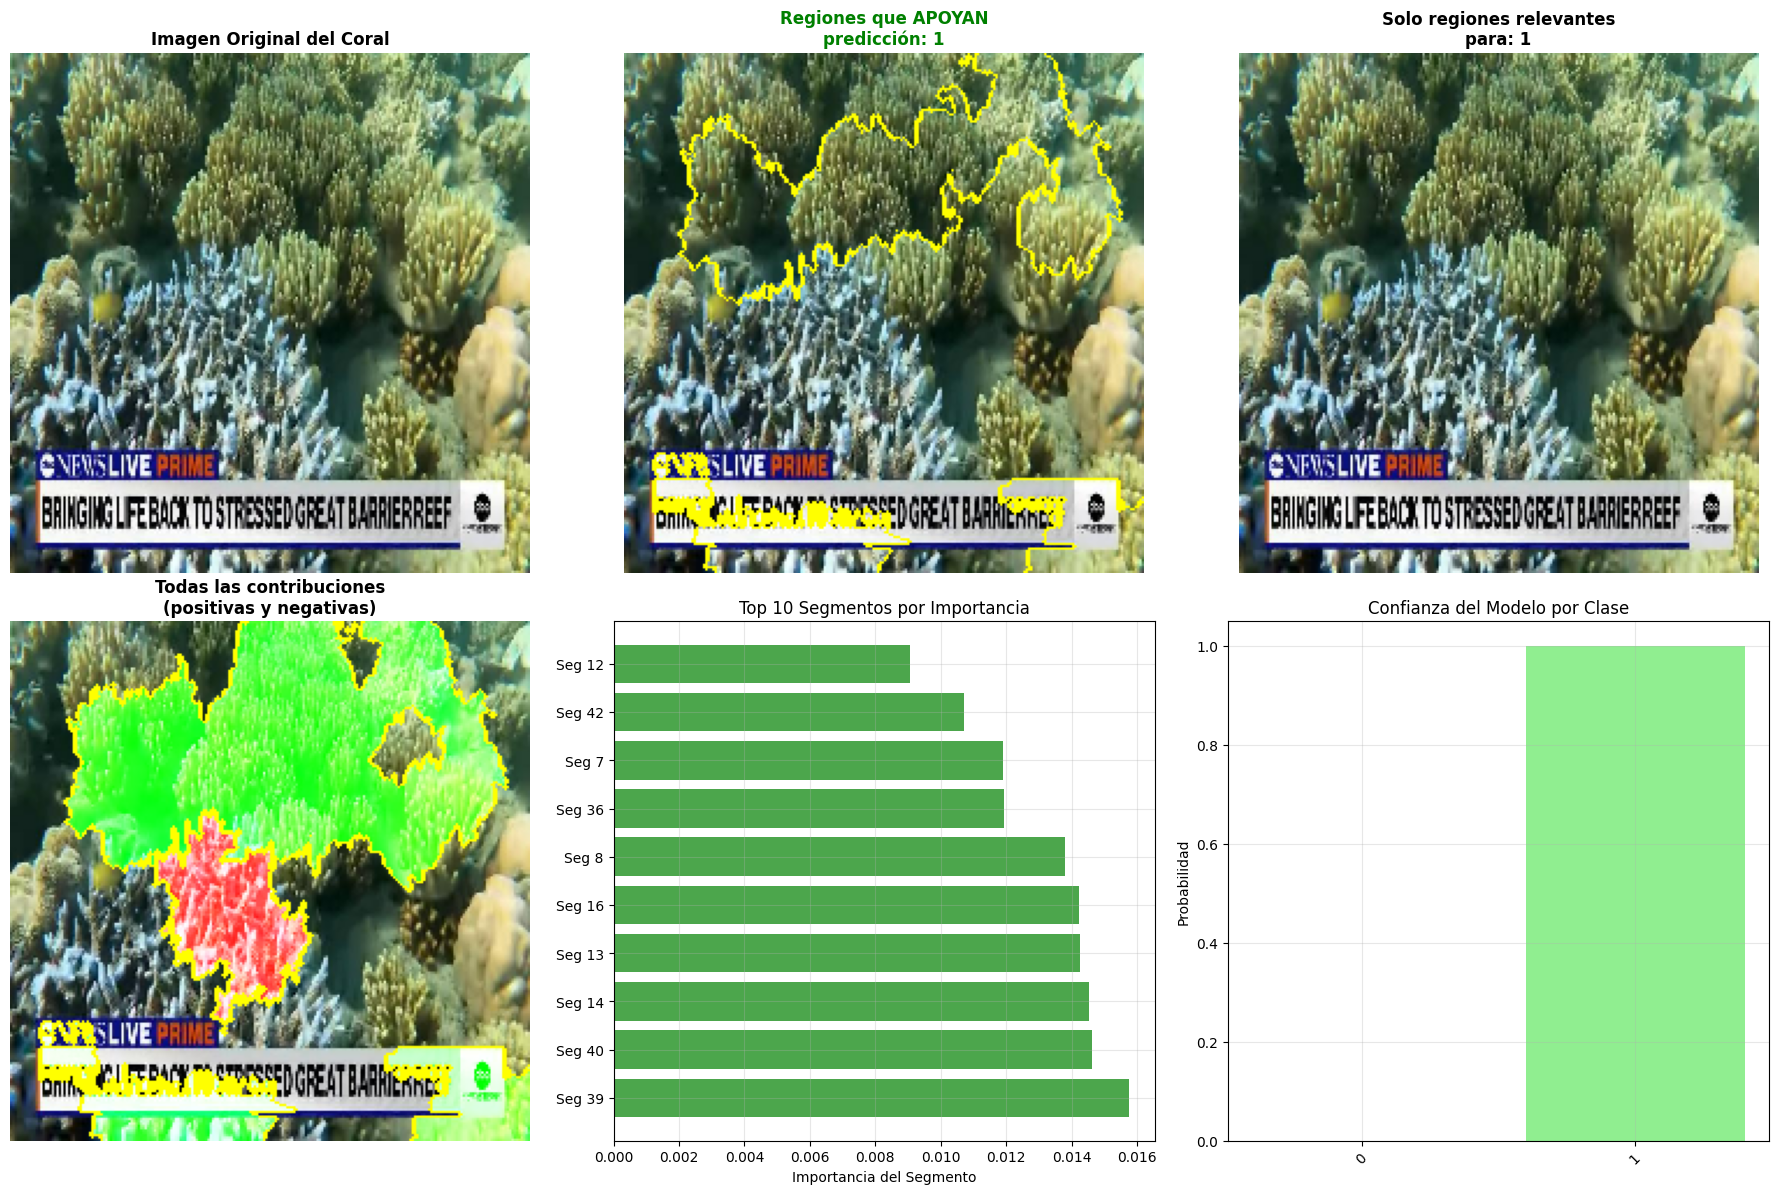


ANÁLISIS LIME PARA: 1
🔍 Confianza del modelo: 1.000
📊 Segmentos que apoyan la predicción: 10
❌ Segmentos que contradicen: 0
➕ Contribución promedio positiva: 0.013
Predicción: 1 (confianza: 1.000)

--- Análisis LIME #2 ---
Imagen: youtube-644_jpg.rf.70752de34d478d174d59e42a9e846320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Generando explicación LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

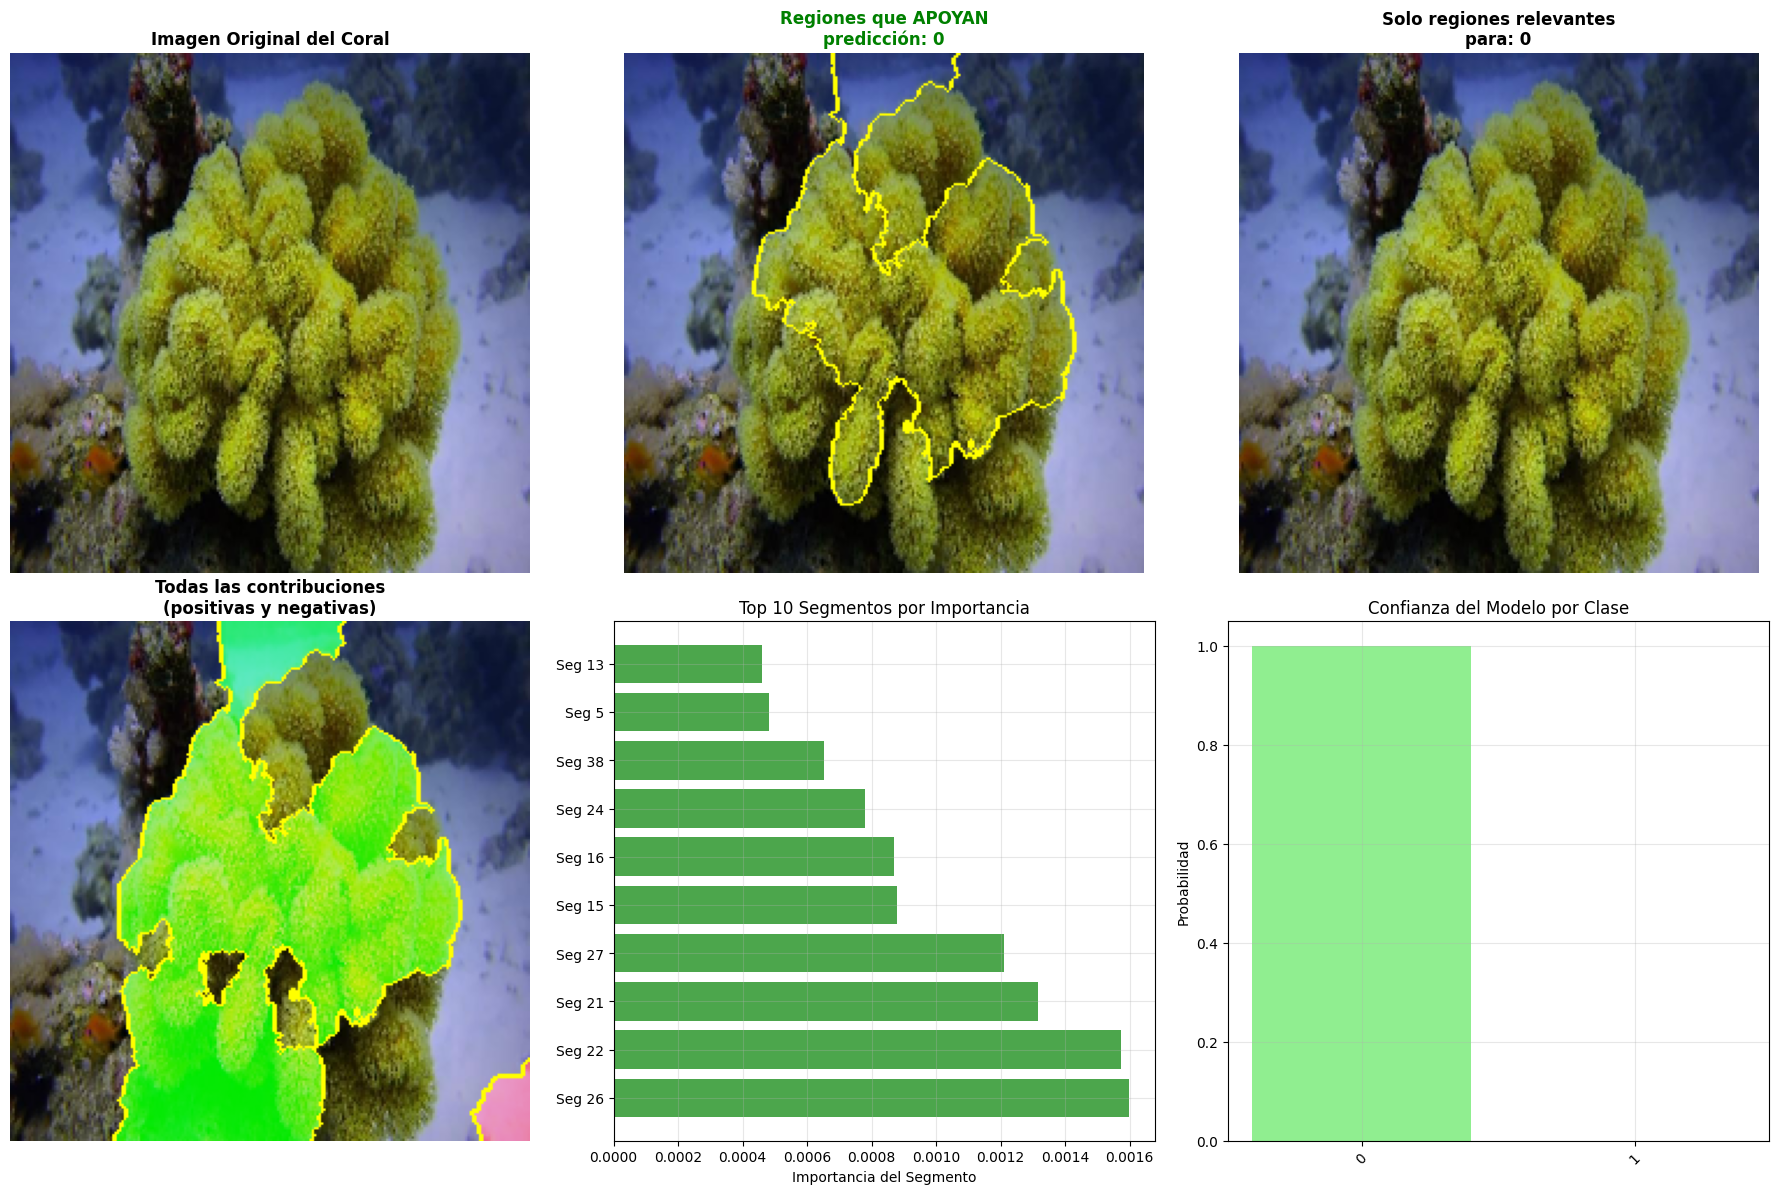


ANÁLISIS LIME PARA: 0
🔍 Confianza del modelo: 1.000
📊 Segmentos que apoyan la predicción: 10
❌ Segmentos que contradicen: 0
➕ Contribución promedio positiva: 0.001
Predicción: 0 (confianza: 1.000)

--- Análisis LIME #3 ---
Imagen: youtube-132_jpg.rf.aa4b2374713ccefd6fce01a5c434f5d7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Generando explicación LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

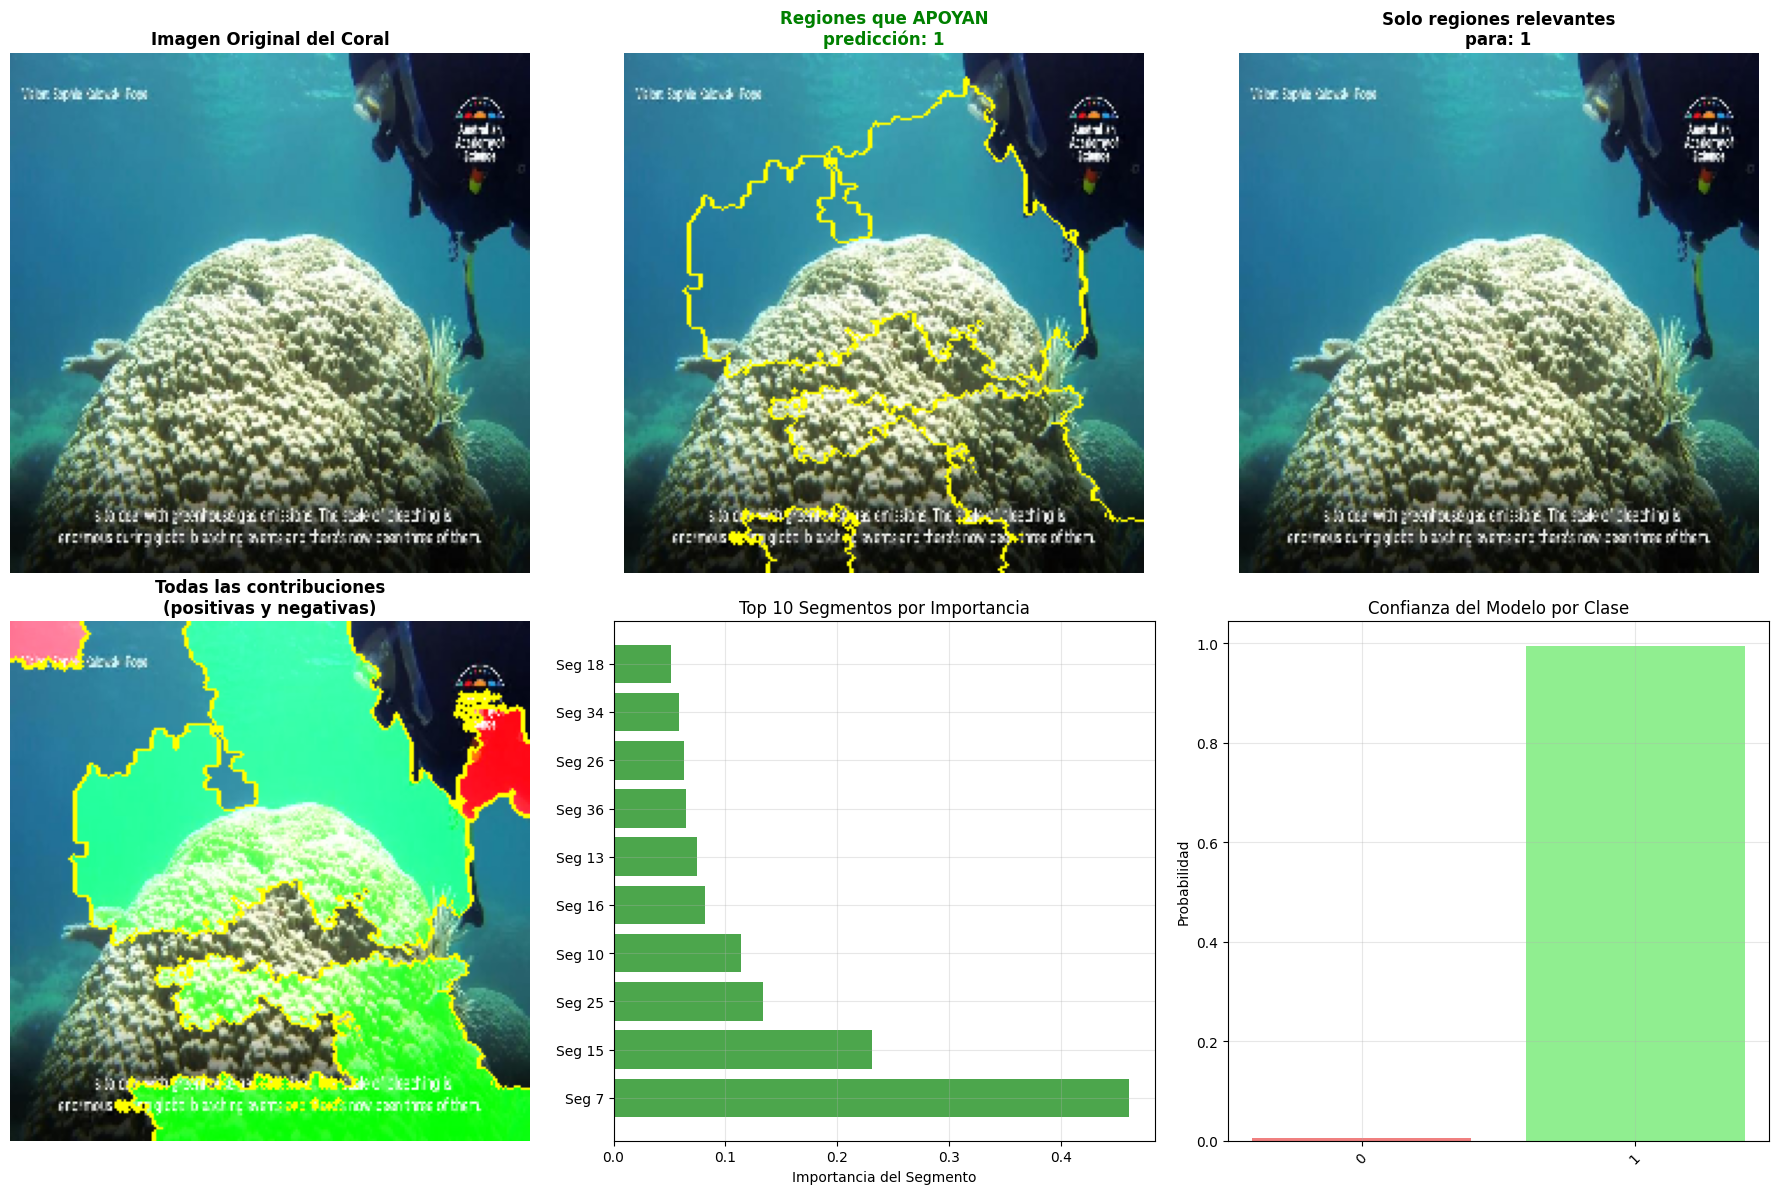


ANÁLISIS LIME PARA: 1
🔍 Confianza del modelo: 0.995
📊 Segmentos que apoyan la predicción: 10
❌ Segmentos que contradicen: 0
➕ Contribución promedio positiva: 0.133
Predicción: 1 (confianza: 0.995)

🚀 PASO 2: Ejemplo manual de LIME...
🖼️ Analizando imagen: youtube-375_jpg.rf.02524f324c2ee8552fa05450d4a6a75f.jpg

📊 Generando explicación LIME...


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━

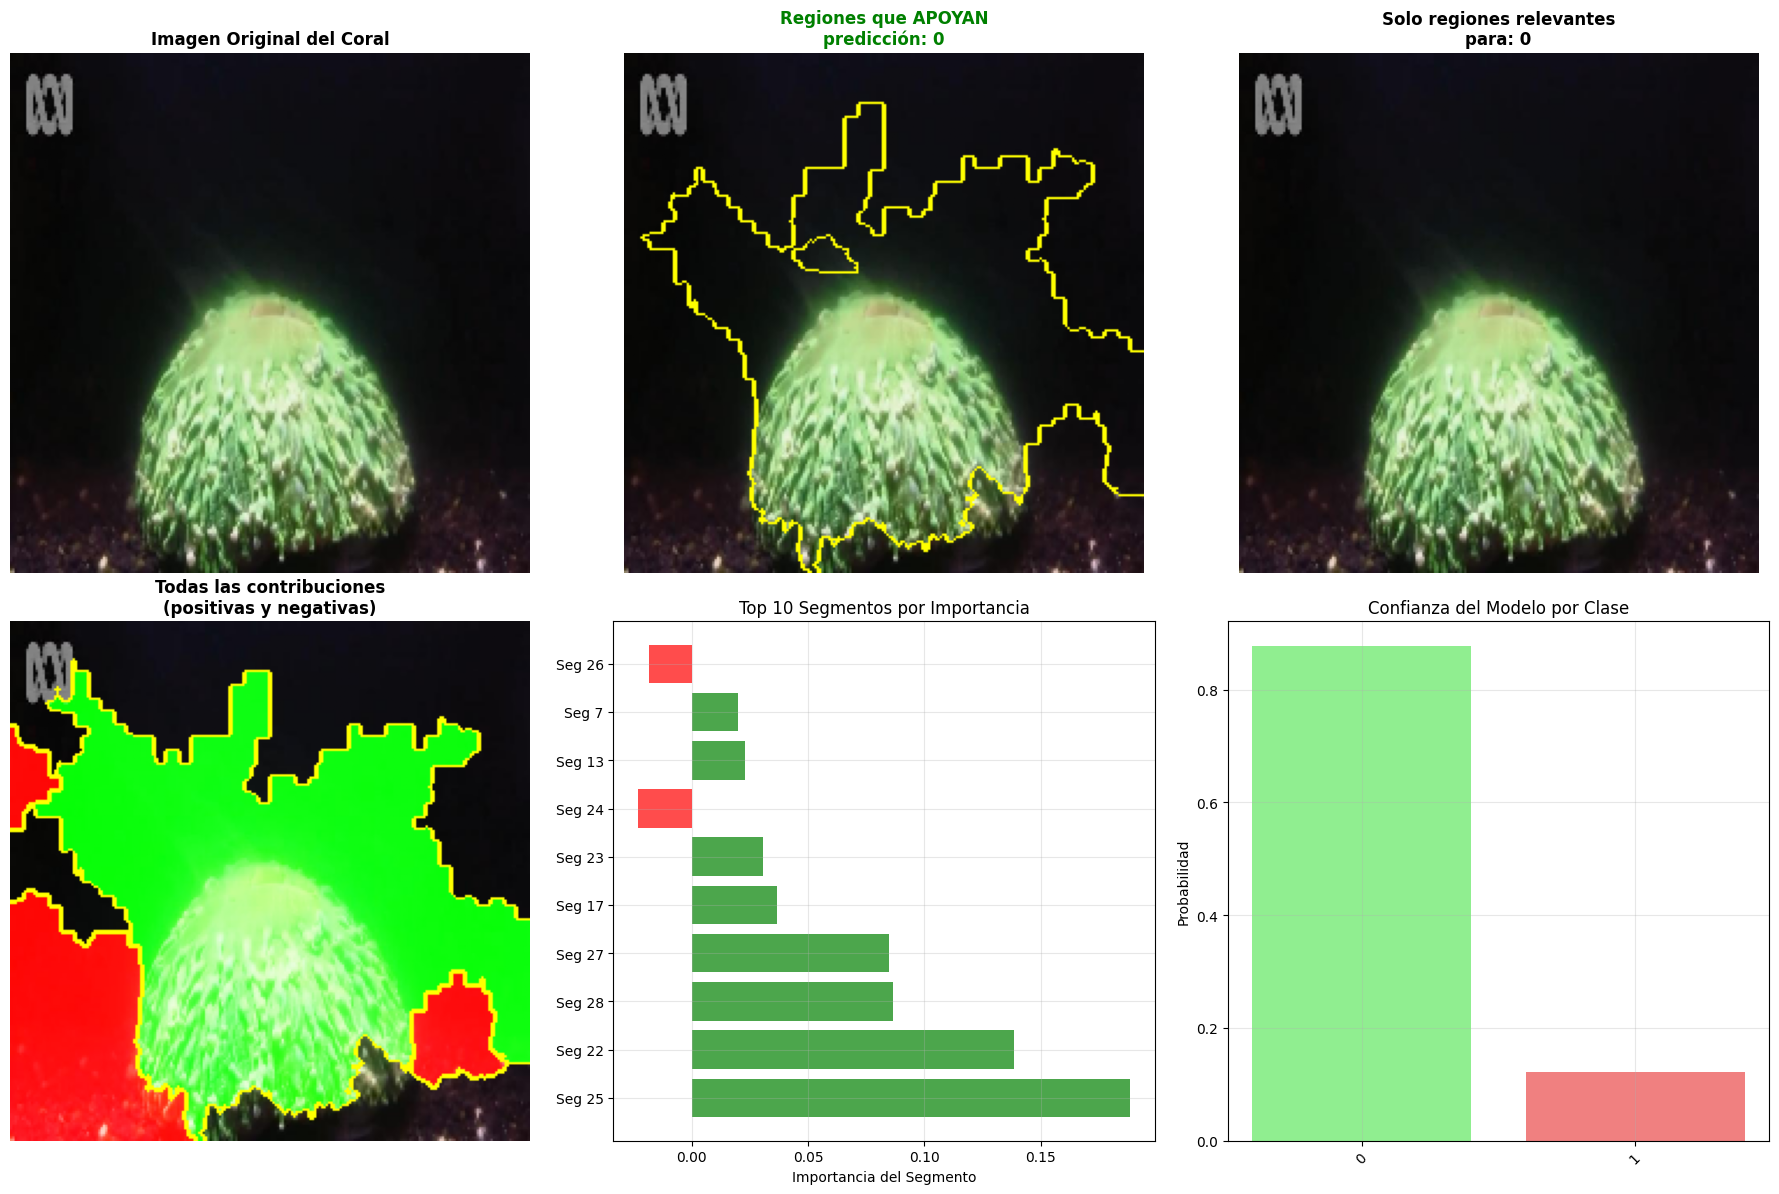


ANÁLISIS LIME PARA: 0
🔍 Confianza del modelo: 0.878
📊 Segmentos que apoyan la predicción: 8
❌ Segmentos que contradicen: 2
➕ Contribución promedio positiva: 0.076
➖ Contribución promedio negativa: -0.021
✅ ¡Análisis LIME completado!


In [ ]:
# ========================================
# EJECUTAR LIME EXPLÍCITAMENTE
# ========================================

print("\n" + "🔍"*20)
print("INICIANDO ANÁLISIS LIME")
print("🔍"*20)

# Paso 1: Ejecutar la demostración automática
print("\n🚀 PASO 1: Ejecutando demostración automática de LIME...")
demo_lime_coral_analysis()

# Paso 2: Ejemplo manual con una imagen específica
print("\n🚀 PASO 2: Ejemplo manual de LIME...")

try:
    # Obtener una imagen específica del test set
    if hasattr(test_generator, 'dataframe'):
        sample_df = test_generator.dataframe.sample(n=1)
        sample_image_path = sample_df['filepath'].iloc[0]
    else:
        # Buscar manualmente una imagen
        sample_image_path = None
        for root, dirs, files in os.walk(test_dir):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    sample_image_path = os.path.join(root, file)
                    break
            if sample_image_path:
                break

    if sample_image_path and os.path.exists(sample_image_path):
        print(f"🖼️ Analizando imagen: {os.path.basename(sample_image_path)}")

        # EJECUTAR LIME PASO A PASO
        print("\n📊 Generando explicación LIME...")
        explanation, image = explain_coral_prediction(sample_image_path, num_samples=500)

        print("✅ Explicación generada exitosamente!")

        # Obtener predicción del modelo
        prediction = model.predict(np.expand_dims(image, axis=0))[0]
        predicted_class = np.argmax(prediction)
        confidence = prediction[predicted_class]

        print(f"🎯 Predicción: {class_names[predicted_class]} (confianza: {confidence:.3f})")

        # VISUALIZAR EXPLICACIÓN
        print("\n🎨 Generando visualización...")
        visualize_lime_explanation(explanation, image, predicted_class)

        print("✅ ¡Análisis LIME completado!")

    else:
        print("❌ No se encontró una imagen válida para el análisis")

except Exception as e:
    print(f"❌ Error ejecutando LIME: {e}")
    print("💡 Intentando método alternativo...")
